In [1]:
from cmdstanpy import CmdStanModel
import arviz as az

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dp_mix_stan = """
data
{
    int I; // number of areal locations
    int T; // number of time steps
    int P; // number of covariates
    int H; // truncation of stick breaking construction dp
    
    array[I] vector[T] y; // value of interest
    array[I] matrix[T,P+1] X; // covariates matrices for each province
      
    // hyperpar vector of regressors
    vector[P+1] mu_0; 
    real        sigma_0;
    
    // mean of w_1 (random effect for every province at time 1)
    vector[I] mu_w_1;
    
    // alpha
    real a_alpha;
    real b_alpha;
    
    // tau^2
    real a_tau2;
    real b_tau2;
    
    // sigma^2
    real a_sigma2;
    real b_sigma2;
    
    // rho 
    real rho;
    
    //xis
    real a_xi;
    real b_xi;

    // Qinv
    matrix[I,I] inv_Q;
}

transformed data {
    matrix[I, I] L;
    L = cholesky_decompose(inv_Q);
}

parameters
{
    real<lower=0> alpha;
    real<lower=0> sigma2; 
    real<lower=0> tau2;  
    
    // autoregressive coefficient construction
    real<lower=0,upper=1> xi_constructor;
    
    // betas for the mixture of the dirichlet process
    array[H] vector[P+1] betas; 

    // for the construction of the dirichlet process
    vector<lower=0,upper=1>[H-1] vs;
    
    // for the random effect construction 
    array[T] vector[I] w_raw;
}

transformed parameters
{   
    // weights stick breaking construction
    simplex[H] omegas; 
    
    // sbc stuff
    vector[H-1] cumprod_one_mv;    
    cumprod_one_mv = exp(cumulative_sum(log1m(vs)));
    
    omegas[1] = vs[1];
    omegas[2:(H-1)] = vs[2:(H-1)] .* cumprod_one_mv[1:(H-2)];
    omegas[H] = cumprod_one_mv[H-1];
    
    // autoregressive coefficient of the random effects
    real xi = 2*xi_constructor-1;
    
    // random effects tmp
    matrix[I,T]                ws_tmp;
    
    ws_tmp[1:I,1] =  mu_w_1 + L*w_raw[1];
    
    for (t in 2:T)
        ws_tmp[1:I,t] = ws_tmp[1:I,t-1]*xi + L*w_raw[t]; 
    
    matrix[T,I]   ws = (ws_tmp)'; //otherwise I have to transpose in the for loop at each iteration
    
    // Stan wants std
    real sigma = sqrt(sigma2);
    real tau = sqrt(tau2);
}

model
{
    alpha  ~ gamma(a_alpha,b_alpha);
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    vs     ~ beta(1,alpha); 
    xi_constructor ~ beta(a_xi,b_xi);
    
    w_raw[1] ~ normal(0, tau); 
    
    for (t in 2:T)
        w_raw[t] ~ normal(0, tau);
    
    for (h in 1:H)
        betas[h] ~ normal(mu_0, sigma_0);
    
    vector[H] log_probs;
    
    for (i in 1:I) {
        
        for (h in 1:H) 
    
            log_probs[h] = log(omegas[h]) + normal_lpdf(y[i] | X[i]*betas[h] + ws[1:T,i], sigma);
        
        target += log_sum_exp(log_probs);
    }
}

generated quantities 
{   
    // vector of cluster allocations
    vector[I] s;
    
    // log likelihood for each areal location 
    vector[I] log_lik;
    
    array[I] vector[H] log_probs;
    
    for (i in 1:I) 
    {
        for (h in 1:H) 
            log_probs[i,h] = log(omegas[h]) + normal_lpdf(y[i] | X[i]*betas[h] + ws[1:T,i], sigma);
        
        s[i] = categorical_rng(softmax(log_probs[i]));
        
        log_lik[i] = log_sum_exp(log_probs[i]);
    }
    
        
}
"""

stan_file = "stan_files/Model_simulated_data.stan"

with open(stan_file, "w") as fp:
    fp.write(dp_mix_stan)
    
dp_mix = CmdStanModel(stan_file=stan_file)

17:50:42 - cmdstanpy - INFO - compiling stan file /home/daan/bayesian-project/stan_files/Model_simulated_data.stan to exe file /home/daan/bayesian-project/stan_files/Model_simulated_data
17:51:01 - cmdstanpy - INFO - compiled model executable: /home/daan/bayesian-project/stan_files/Model_simulated_data


In [2]:
np.random.seed(120) 

I = 100
T = 10
P = 3
num_clus = 7
true_beta_means=np.array([[0.2,0.2,0.2,0.2],[-1,-1,-1,-1],[2,2,2,2],[-3,-3,-3,-3],[-5,-5,-5,-5],[4,4,4,4],
                   [6,6,6,6]])
W_raw= np.zeros((I,I))
true_clus=np.zeros((I,1),int)

beta = np.zeros((num_clus,P+1))
for i in range(num_clus):
    beta[i,0:] = np.random.multivariate_normal(mean=true_beta_means[i],cov = np.eye(P+1));
    
#Put the i in a matrix(10x10) saved by the sequence of rows
# W(i,j)=1 if i and j have a shared side or corner
# Divided in 7 groups as in paper
Square_clus= np.zeros((10,10))
Square_clus[2:,0:4]=np.ones((8,4))
Square_clus[0:2,2:4]=2*np.ones((2,2))
Square_clus[0:8,4:]=4*np.ones((8,6))
Square_clus[0:4,4:6]=2*np.ones((4,2))
Square_clus[0:3,8:]=5*np.ones((3,2))
Square_clus[4:6,4:7]=3*np.ones((2,3))
Square_clus[8:,4:]=6*np.ones((2,6))
for i in range(I):
    W_raw[i,i]=1
    col_ind_i=int(i%10)
    row_ind_i=int((i-col_ind_i)/10)
    true_clus[i]= Square_clus[row_ind_i,col_ind_i]
    for j in range(i):
        col_ind_j=int(j%10)
        row_ind_j=int((j-col_ind_j)/10)
        
        if(abs(row_ind_i-row_ind_j)<=1 and abs(col_ind_i-col_ind_j)<=1):
            W_raw[i,j]=1
            W_raw[j,i]=1
            
#Build X random
X_tmp = np.ones((I*T,P+1)) # in this way the first column is made by one
for i in range(I*T):
    X_tmp[i,1:] = np.random.normal(loc=1,size= P) #the other P covariates are choosen randomly

X = []
for i in range(I):
    X.append(X_tmp[T*(i):T*(i+1),0:])
    
X = np.array(X)
print(X.shape)

#Build xis
tau2=1
rho=0.95
v=np.matmul(W_raw,np.ones((I,1)))
v=np.reshape(v,I)
invQ=np.linalg.inv(rho*(np.diag(v)-W_raw)+(1-rho)*np.eye(I))
diag_matrix_xis=0.05*np.eye(I) #diag(xis) 

for i in range(I):
  for j in range(I):
    invQ[j,i] = invQ[i,j]

#Build W temporal autoregressive element
W=np.zeros((I,T))
W[:,0]=np.random.multivariate_normal(mean=np.zeros(I),cov=invQ*tau2)
for t in range(T-1):
    W[:,t+1]=np.random.multivariate_normal(mean=np.matmul(diag_matrix_xis,W[:,t]), cov=invQ*tau2)

#Build y
y = []
y_temp = np.zeros(T)
for i in range(I): #for each areal location 
    loc= np.matmul(X[i],np.transpose(beta[true_clus[i],:]))+ np.reshape(W[i,:],(10,1))
    y_temp = np.random.multivariate_normal(mean= np.squeeze(loc), cov=np.eye(T))
    y.append(y_temp)
    # this are the data related to areal i for all time until T
    
y = np.array(y)
print(y.shape)
print(Square_clus)
#plt.hist(np.reshape(y,(I*T,1)))
# print(np.linalg.eig(invQ))

print(np.var(np.reshape(y,(I*T,1))))
print(np.mean(np.reshape(y,(I*T,1))))
print(X.shape)

np.savetxt("outputs/simulated_true_clusters.csv", Square_clus, delimiter=",")

(100, 10, 4)
(100, 10)
[[0. 0. 2. 2. 2. 2. 4. 4. 5. 5.]
 [0. 0. 2. 2. 2. 2. 4. 4. 5. 5.]
 [1. 1. 1. 1. 2. 2. 4. 4. 5. 5.]
 [1. 1. 1. 1. 2. 2. 4. 4. 4. 4.]
 [1. 1. 1. 1. 3. 3. 3. 4. 4. 4.]
 [1. 1. 1. 1. 3. 3. 3. 4. 4. 4.]
 [1. 1. 1. 1. 4. 4. 4. 4. 4. 4.]
 [1. 1. 1. 1. 4. 4. 4. 4. 4. 4.]
 [1. 1. 1. 1. 6. 6. 6. 6. 6. 6.]
 [1. 1. 1. 1. 6. 6. 6. 6. 6. 6.]]
246.20076519287562
-1.3197152637362366
(100, 10, 4)


In [3]:
mu_0 = np.zeros(P+1) #as in the paper
mu_w_1 = np.zeros(I) #as in the paper
sigma_0 = 1 #covariance matrix
H = 10

data = {
    "I": I,
    "T": T,
    "P": P,
    "H": H,
    "y": y,
    "X": X,
    "mu_0": mu_0,
    "sigma_0": sigma_0,
    "mu_w_1": mu_w_1,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "rho": 0.95,
    "a_xi": 1,
    "b_xi": 1,
    "inv_Q": invQ
}

In [5]:
num_iter = 10000
num_war = 10000

fit = dp_mix.sample(data
                    , iter_warmup = num_war
                    , iter_sampling = num_iter
                   )

17:51:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:33 - cmdstanpy - INFO - CmdStan done processing.
18:19:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in '/home/daan/bayesian-project/stan_files/Model_simulated_data.stan', line 102, column 4 to column 27)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in '/home/daan/bayesian-project/stan_files/Model_simulated_data.stan', line 102, column 4 to column 27)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/daan/bayesian-project/stan_files/Model_simulated_data.stan', line 105, column 4 to column 30)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in '/home/daan/bayesian-project/stan_files/Model_simulated_data.stan', line 102, column 4 to column 27)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in '/home/daan/bayesian-project/stan_files/Model_simulated_data.stan'

In [6]:
s = (fit.s).astype(int)
np.savetxt("outputs/simulated_posterior_s.csv", s, delimiter=",")
s.shape

(20000, 100)

In [7]:
fit_az = az.from_cmdstanpy(fit)

/home/daan/.local/lib/python3.10/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (16700) in plot_autocorr, generating only 40 plots
  warnings.warn(


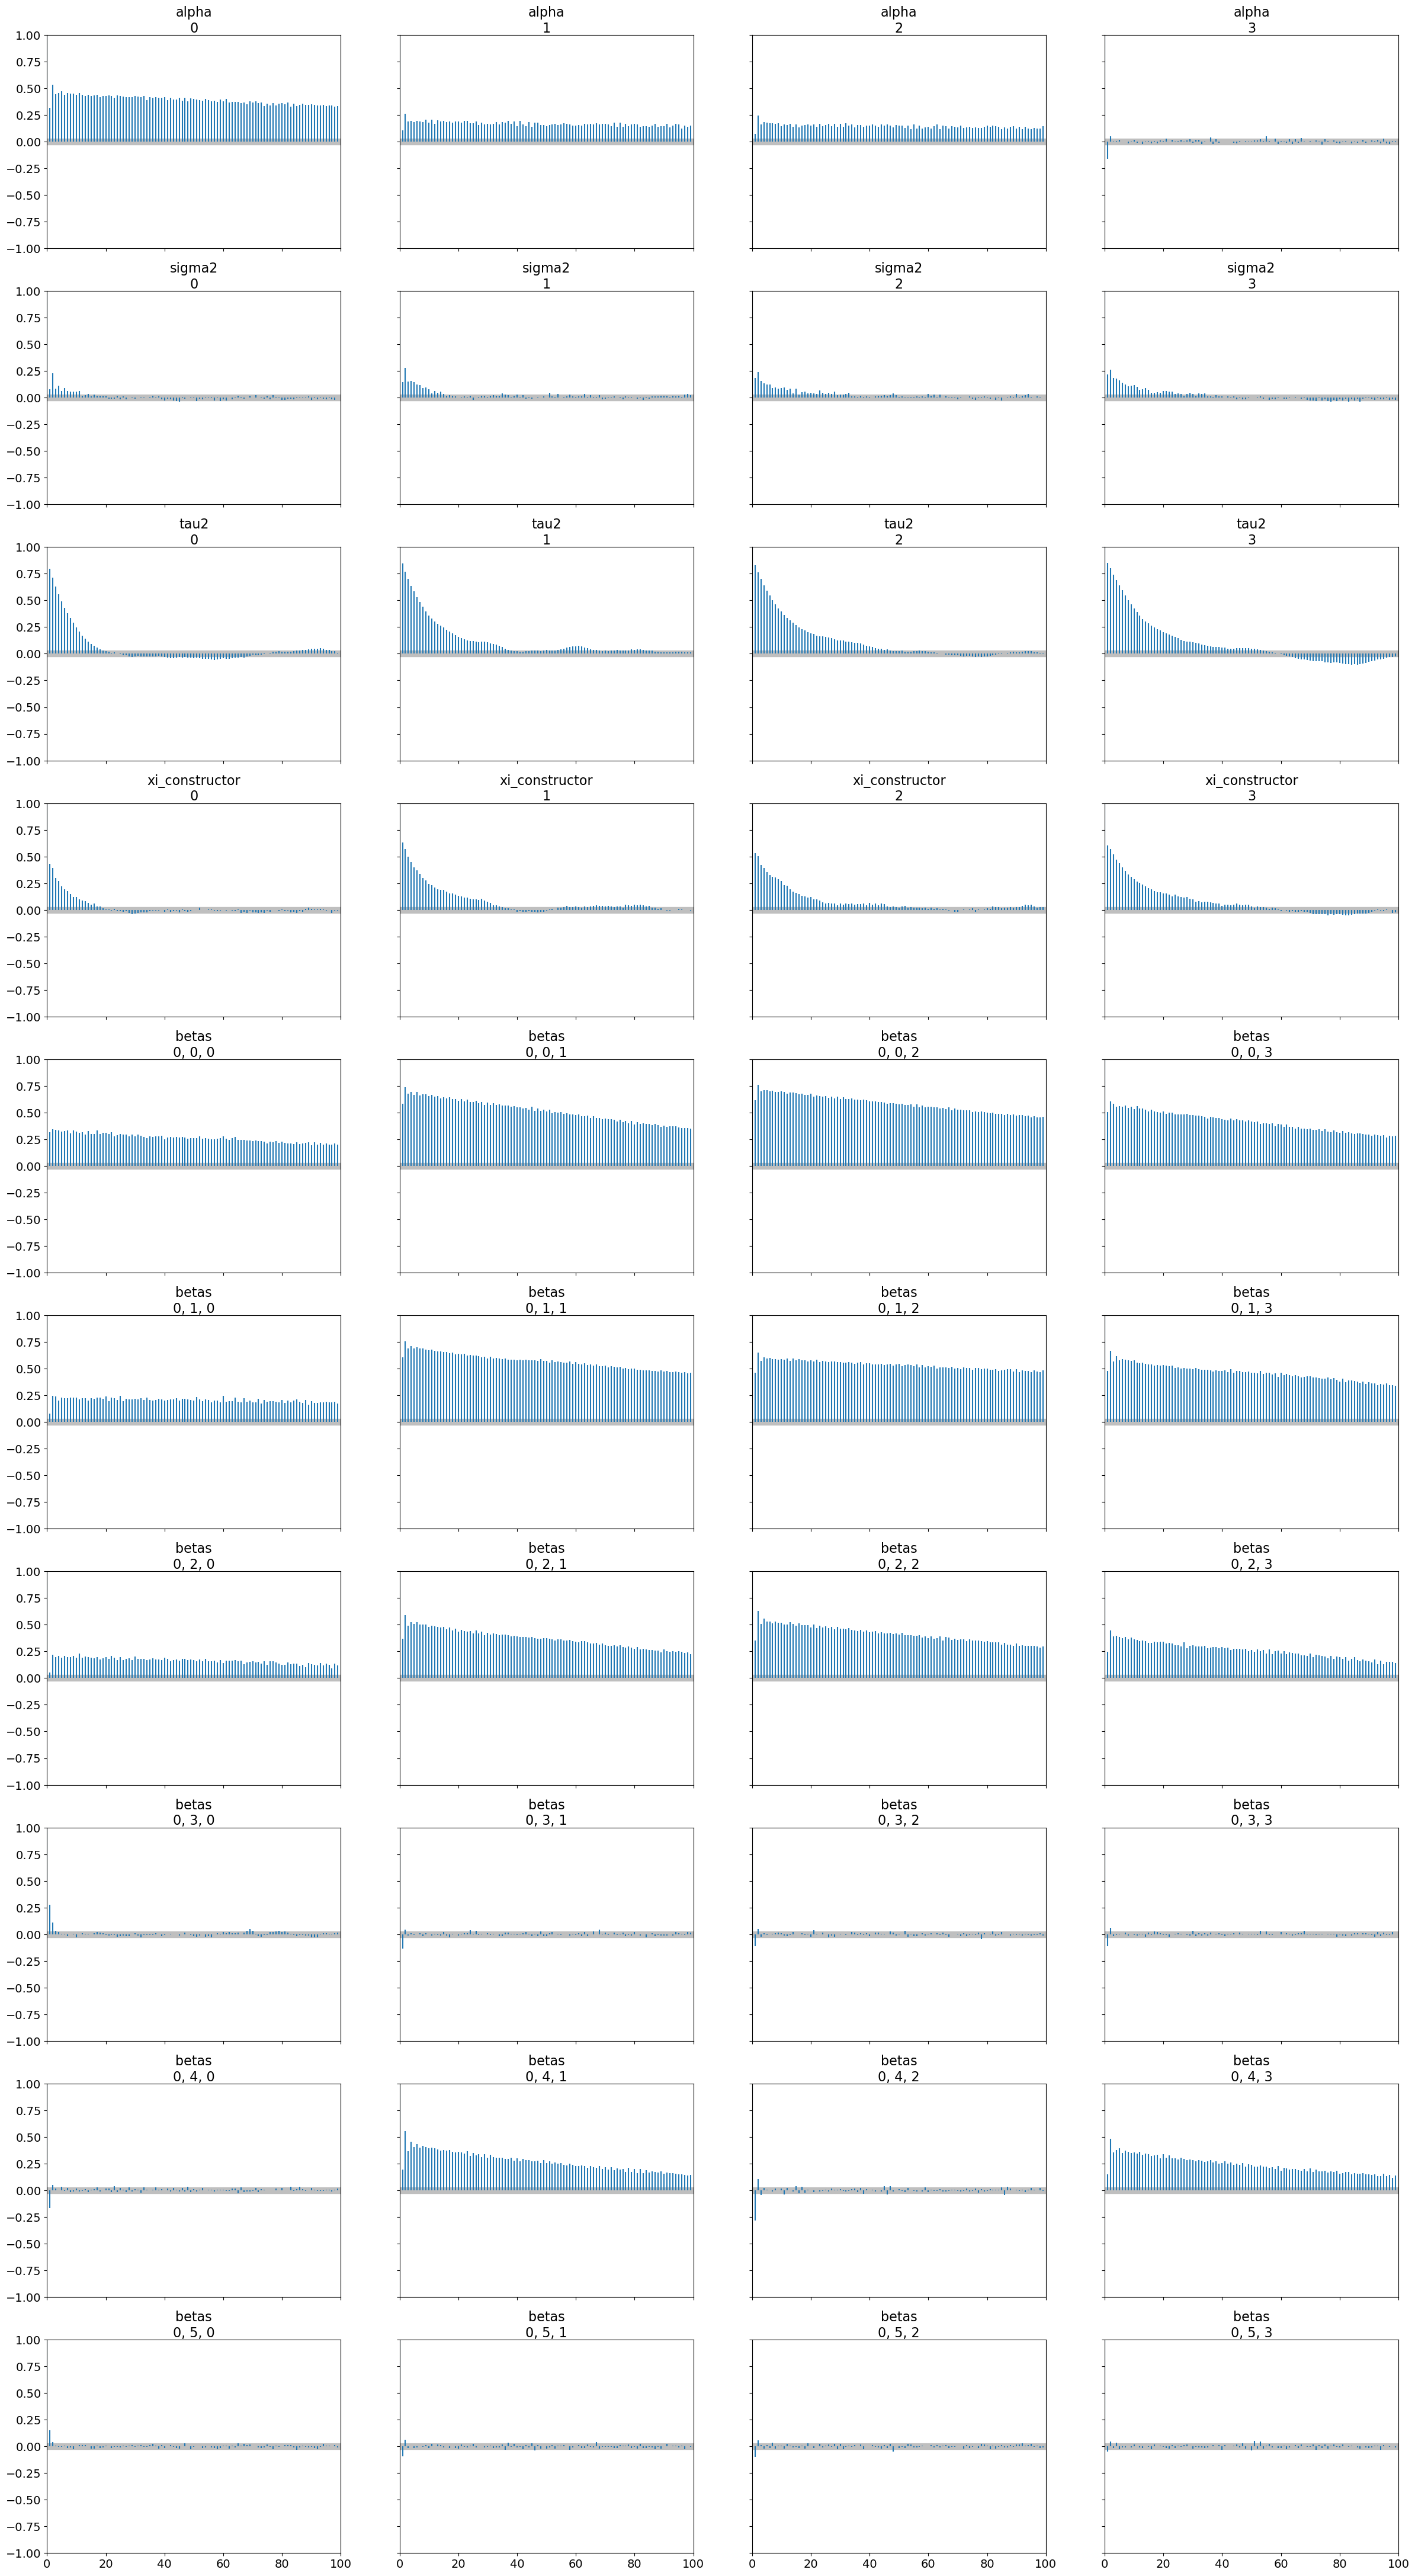

In [10]:
az.plot_autocorr(fit_az)
plt.show()

In [11]:
az.ess(fit_az)

<xarray.Dataset>
Dimensions:               (betas_dim_0: 10, betas_dim_1: 4, vs_dim_0: 9,
                           w_raw_dim_0: 10, w_raw_dim_1: 100, omegas_dim_0: 10,
                           cumprod_one_mv_dim_0: 9, ws_tmp_dim_0: 100,
                           ws_tmp_dim_1: 10, ws_dim_0: 10, ws_dim_1: 100,
                           s_dim_0: 100, log_probs_dim_0: 100,
                           log_probs_dim_1: 10)
Coordinates: (12/14)
  * betas_dim_0           (betas_dim_0) int64 0 1 2 3 4 5 6 7 8 9
  * betas_dim_1           (betas_dim_1) int64 0 1 2 3
  * vs_dim_0              (vs_dim_0) int64 0 1 2 3 4 5 6 7 8
  * w_raw_dim_0           (w_raw_dim_0) int64 0 1 2 3 4 5 6 7 8 9
  * w_raw_dim_1           (w_raw_dim_1) int64 0 1 2 3 4 5 ... 94 95 96 97 98 99
  * omegas_dim_0          (omegas_dim_0) int64 0 1 2 3 4 5 6 7 8 9
    ...                    ...
  * ws_tmp_dim_1          (ws_tmp_dim_1) int64 0 1 2 3 4 5 6 7 8 9
  * ws_dim_0              (ws_dim_0) int64 0 1 2 3 4 5 6 7 8 9
  * ws_dim_1              (ws_dim_1) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
  * s_dim_0               (s_dim_0) int64 0 1 2 3 4 5 6 ... 93 94 95 96 97 98 99
  * log_probs_dim_0       (log_probs_dim_0) int64 0 1 2 3 4 5 ... 95 96 97 98 99
  * log_probs_dim_1       (log_probs_dim_1) int64 0 1 2 3 4 5 6 7 8 9
Data variables: (12/16)
    alpha                 float64 8.51
    sigma2                float64 7.075
    tau2                  float64 8.995
    xi_constructor        float64 8.209
    betas                 (betas_dim_0, betas_dim_1) float64 6.534 ... 6.924
    vs                    (vs_dim_0) float64 8.379 5.717 7.517 ... 6.806 11.26
    ...                    ...
    ws_tmp                (ws_tmp_dim_0, ws_tmp_dim_1) float64 78.52 ... 1.91...
    ws                    (ws_dim_0, ws_dim_1) float64 78.52 45.13 ... 1.91e+04
    sigma                 float64 7.075
    tau                   float64 8.995
    s                     (s_dim_0) float64 50.87 50.83 4.006 ... 4.006 4.006
    log_probs             (log_probs_dim_0, log_probs_dim_1) float64 5.205 .....

In [4]:
with open("outputs/simulated_s_binder.csv", "rb") as f:
    s_binder=pd.read_csv(f)
s_fixed= np.array(s_binder['V1'])
print(s_fixed.reshape((10,10)))
Square_clus

[[1 1 2 2 2 2 3 3 4 4]
 [1 1 2 2 2 2 3 3 4 4]
 [5 5 5 5 2 2 3 3 4 4]
 [5 5 5 5 2 2 3 3 3 3]
 [5 5 5 5 6 6 6 3 3 3]
 [5 5 5 5 6 6 6 3 3 3]
 [5 5 5 5 3 3 3 3 3 3]
 [5 5 5 5 3 3 3 3 3 3]
 [5 5 5 5 7 7 7 7 7 7]
 [5 5 5 5 7 7 7 7 7 7]]


array([[0., 0., 2., 2., 2., 2., 4., 4., 5., 5.],
       [0., 0., 2., 2., 2., 2., 4., 4., 5., 5.],
       [1., 1., 1., 1., 2., 2., 4., 4., 5., 5.],
       [1., 1., 1., 1., 2., 2., 4., 4., 4., 4.],
       [1., 1., 1., 1., 3., 3., 3., 4., 4., 4.],
       [1., 1., 1., 1., 3., 3., 3., 4., 4., 4.],
       [1., 1., 1., 1., 4., 4., 4., 4., 4., 4.],
       [1., 1., 1., 1., 4., 4., 4., 4., 4., 4.],
       [1., 1., 1., 1., 6., 6., 6., 6., 6., 6.],
       [1., 1., 1., 1., 6., 6., 6., 6., 6., 6.]])

In [13]:
np.savetxt("outputs/simulated_dataset_posterior_xi.csv", fit.xi, delimiter=",")
np.savetxt("outputs/simulated_dataset_posterior_alpha.csv", fit.alpha, delimiter=",")

In [5]:
# Fixed clustering s to study betas depending on clusters
beta_clus_stan = """
data
{
    int I; // number of areal locations
    int T; // number of time steps
    int P; // number of covariates
    int N; // number of clusters
    
    array[I] vector[T] y; // value of interest
    array[I] matrix[T,P+1] X; // covariates matrices for each province
      
    // hyperpar vector of regressors
    vector[P+1] mu_0; 
    real        sigma_0;
    
    // mean of w_1 (random effect for every province at time 1)
    vector[I] mu_w_1;
    
    // alpha
    real a_alpha;
    real b_alpha;
    
    // tau^2
    real a_tau2;
    real b_tau2;
    
    // sigma^2
    real a_sigma2;
    real b_sigma2;
    
    // rho 
    real rho;
    
    //xis
    real a_xi;
    real b_xi;

    // Qinv
    matrix[I,I] inv_Q;
    
    // s
    array[I] int s;
}

transformed data {
    matrix[I, I] L;
    L = cholesky_decompose(inv_Q);
}

parameters
{
    real<lower=0> sigma2; 
    real<lower=0> tau2;  
    
    // autoregressive coefficient
    real<lower=0,upper=1> xi_constructor;
    
    // betas for the mixture of the dirichlet process
    array[N] vector[P+1] betas;
    
    // for the random effect construction 
    array[T] vector[I] w_raw;
}

transformed parameters
{   
    
    // xi of the random effects
    real xi = 2*xi_constructor-1;
    
    // random effects tmp
    matrix[I,T]                ws_tmp;
    
    ws_tmp[1:I,1] =  mu_w_1 + L*w_raw[1];
    
    for (t in 2:T)
        ws_tmp[1:I,t] = ws_tmp[1:I,t-1]*xi + L*w_raw[t]; 
    
    matrix[T,I]   ws = (ws_tmp)'; //otherwise I have to transpose in the for loop at each iteration
    
    // stan wants std
    real sigma = sqrt(sigma2);
    real tau = sqrt(tau2);

}

model
{
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    for (t in 1:T) 
        w_raw[t] ~ normal(0, tau); 
        
    xi_constructor ~ beta(a_xi,b_xi);
    
    for (n in 1:N)
        betas[n] ~ normal(mu_0, sigma_0);
    
    for (i in 1:I) {
        int clus_i=s[i];
        y[i] ~ normal(X[i]*betas[clus_i] + ws[1:T,i], sigma);
    }
}

"""

stan_file = "stan_files/beta_clus_simulated.stan"

with open(stan_file, "w") as fp:
    fp.write(beta_clus_stan)
    
model_clus_simulated = CmdStanModel(stan_file=stan_file)

11:32:43 - cmdstanpy - INFO - compiling stan file /home/daan/bayesian-project/stan_files/beta_clus_simulated.stan to exe file /home/daan/bayesian-project/stan_files/beta_clus_simulated
11:33:00 - cmdstanpy - INFO - compiled model executable: /home/daan/bayesian-project/stan_files/beta_clus_simulated


In [6]:
s_fixed= s_fixed.astype(int)
s_unique= np.unique(s_fixed)
s=np.zeros(s_fixed.size)
N= s_unique.size
for n in range(N):
    s[np.argwhere(s_fixed==s_unique[n])]=n+1
s= s.astype(int)

In [7]:
data_clus = {
    "I": I,
    "T": T,
    "P": P,
    "N": N,
    "y": y,
    "X": X,
    "mu_0": mu_0,
    "sigma_0": sigma_0,
    "mu_w_1": mu_w_1,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "rho": 0.95,
    "a_xi": 1,
    "b_xi": 1,
    "inv_Q": invQ,
    "s":s
}


In [8]:
fit_clus_simulated = model_clus_simulated.sample(data_clus,
                            iter_warmup = num_war,
                            iter_sampling = num_iter
#                     , show_console = True
#                    , chains=4
#                     , adapt_delta=0.9
#                    , step_size = 1.5
#                    , max_treedepth = 100
                   )

11:33:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:38:30 - cmdstanpy - INFO - CmdStan done processing.
11:38:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/daan/bayesian-project/stan_files/beta_clus_simulated.stan', line 92, column 8 to column 34)
Consider re-running with show_console=True if the above output is unclear!


/home/daan/.local/lib/python3.10/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (28), generating only 20 plots
  warnings.warn(


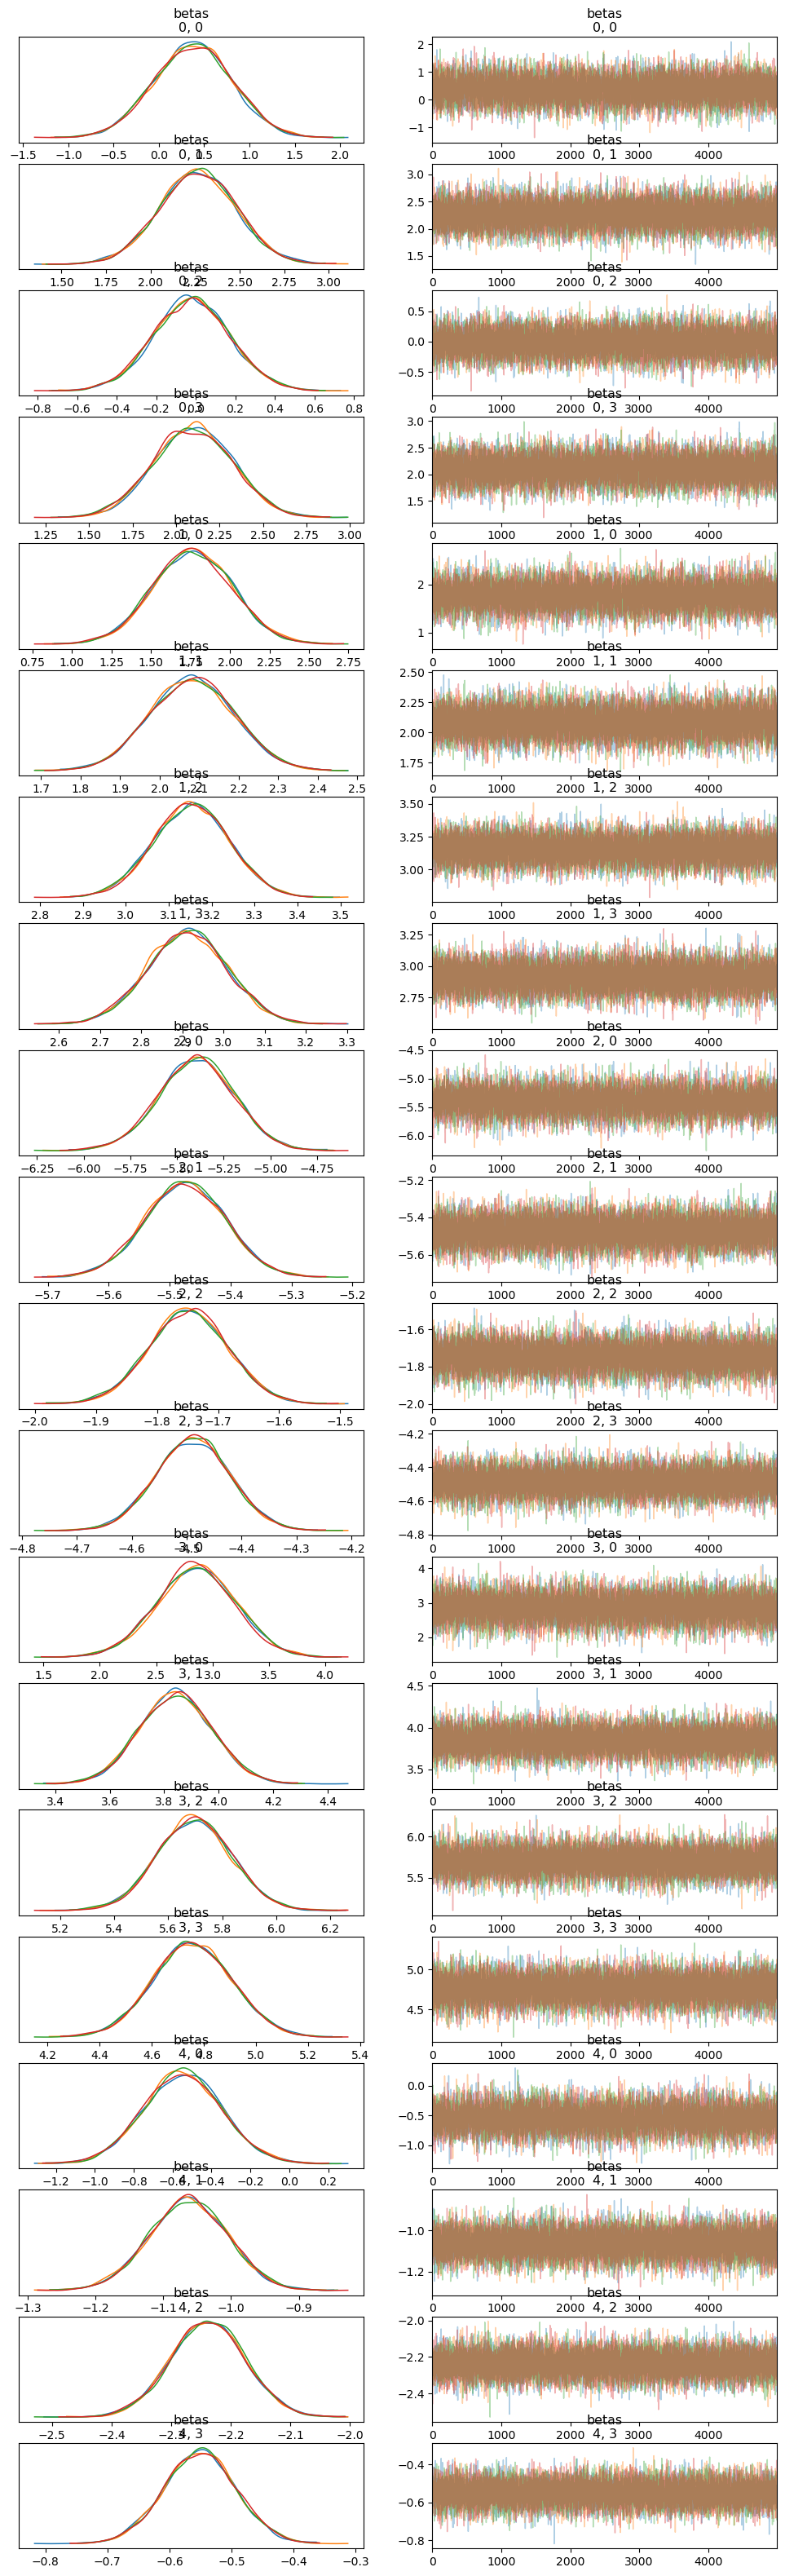

In [26]:
clus_fit_az = az.from_cmdstanpy(fit_clus_simulated)
az.plot_trace(clus_fit_az,var_names=["betas"], compact = False)
plt.show()

In [11]:
betas = fit_clus_simulated.betas
betas.shape
n_clusters = N
beta_means = np.zeros((P+1,n_clusters))

for c in range(P+1):
    for j in range(n_clusters):
        beta_means[c,j] = np.mean(betas[:,j,c])
        
        
np.savetxt("outputs/beta_means_simulated_dataset.txt",beta_means)
beta_means

array([[ 0.38306717,  1.76446724, -5.3929547 ,  2.85638132, -0.54206747,
        -2.33613776,  5.12285446],
       [ 2.26451655,  2.08359074, -5.47503785,  3.84202597, -1.06368011,
        -3.01013095,  6.24993763],
       [-0.0195737 ,  3.15307915, -1.74843675,  5.69683641, -2.2383306 ,
        -3.78450564,  5.07725324],
       [ 2.0970792 ,  2.91240959, -4.48852853,  4.75832399, -0.55184281,
        -3.15054598,  6.14380171]])

In [12]:
for j in range(n_clusters):
    filename = "outputs/betas_cluster_simulated_dataset"+str(j+1)+".csv"
    header = ["X0","X1","X2","X3"]
    df = pd.DataFrame(betas[:,j,:])
    df.to_csv(filename, header=header)